# Project Overview
A fully automated Python pipeline for quantifying collagen fiber morphology across 10 different metrics and four experimental conditions. Includes data preprocessing, outlier removal, statistical testing (ANOVA, PCA), and generation of publication-ready visualizations.

# Import Required Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Data Loading and Preprocessing

In [12]:
# read
df = pd.read_csv("/content/Picrosirius_WB_AllParams.csv")
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation
0,46_MXD_WB_L1,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0
1,46_MXD_WB_L1_2,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7
2,46_MXD_WB_L2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1
3,46_MXD_WB_L2_2,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8
4,46_MXD_WB_R1,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8


In [13]:
# create new "Condition" column
df['Condition'] = df['Slide'].str.split('_').str[1]
df.head()

,Slide,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation,Condition
0,46_MXD_WB_L1,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,MXD
1,46_MXD_WB_L1_2,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,MXD
2,46_MXD_WB_L2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,MXD
3,46_MXD_WB_L2_2,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,MXD
4,46_MXD_WB_R1,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,MXD


In [14]:
# encode conditions (easier to deal with all numeric data)
le = LabelEncoder()
df['Condition_Encoded'] = le.fit_transform(df['Condition'])
print(dict(zip(le.classes_, le.transform(le.classes_))))

# drop original conditions and slide column
df.drop(columns = ['Condition', 'Slide'], inplace = True)
df.head()

{'AXD': np.int64(0), 'MXD': np.int64(1), 'PXD': np.int64(2), 'SXD': np.int64(3)}


,Width,Length,Straightness,Angle,FeatNumCT,FeatNumCA,Alignment_CA,Alignment_MF,Kurtosis,Orientation,Condition_Encoded
0,7.5,62.8,0.94,127.1,105,692,0.59,0.5211,0.43,152.0,1
1,6.8,51.5,0.95,119.8,41,454,0.66,0.6196,0.37,141.7,1
2,7.7,69.2,0.96,56.8,50,541,0.71,0.4178,0.43,27.1,1
3,7.4,65.4,0.93,133.0,248,946,0.77,0.7035,0.50,146.8,1
4,6.7,56.7,0.94,124.9,51,502,0.60,0.4512,0.37,144.8,1


# PCA Workflow

In [15]:
# ensure all values are numeric
for col in df.columns:
  df[col] = pd.to_numeric(df[col])

# scale data
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_data

array([[ 1.7880941 , -0.01038831, -0.8554415 , ..., -0.72743322,
         0.84646976, -0.3619576 ],
       [-0.0447583 , -0.92601417,  0.09776474, ..., -1.07131074,
         0.66039835, -0.3619576 ],
       [ 2.31176622,  0.50819624,  1.05097099, ..., -0.72743322,
        -1.40987196, -0.3619576 ],
       ...,
       [-0.83026647, -0.93411706, -0.8554415 , ..., -1.70175287,
         0.6658179 , -1.24422926],
       [-1.09210253,  1.98292108,  1.05097099, ...,  1.27851899,
         0.81395243, -1.24422926],
       [-1.35393859, -0.05090273,  1.05097099, ...,  1.62239652,
         0.83563065, -1.24422926]])

In [16]:
# run PCA
pca = PCA(n_components=3)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
x_pca.shape

(117, 3)

In [17]:
# create new df for PCA data
pca_df = pd.DataFrame(x_pca, columns = ['PC1', 'PC2', 'PC3'])
pca_df['Condition'] = df['Condition_Encoded']

# map original conditions back to encoded condition
name_map = {
    0: 'Condition 1',
    1: 'Condition 2',
    2: 'Condition 3',
    3: 'Condition 4'
}

pca_df['Condition'] = pca_df['Condition'].map(name_map)
pca_df.head()

,PC1,PC2,PC3,Condition
0,-1.853626,0.404481,2.767047,Condition 2
1,-2.389440,-0.031442,0.202589,Condition 2
2,-1.284870,-2.833016,2.214590,Condition 2
3,0.481459,1.779708,2.522326,Condition 2
4,-2.944571,0.020967,1.279381,Condition 2


In [18]:
# check percentage of variance explained by each PC
percentage_pca = pca.explained_variance_ratio_*100
print(percentage_pca)

[37.57566235 20.12870304 15.17801958]


# Visualization

In [19]:
# x and y label font size
font_size = 20

# specify order
desired_order = ['Condition 4', 'Condition 2', 'Condition 1', 'Condition 3']

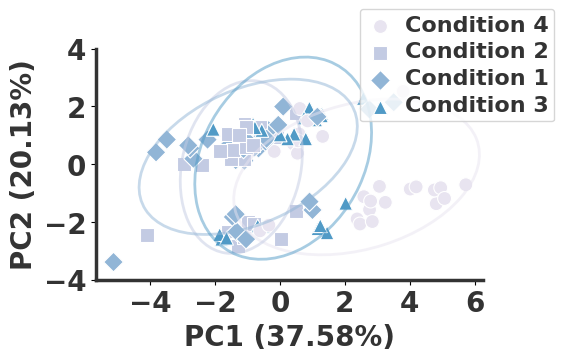

In [20]:
# plot PCA
custom_palette = ["#E8E4F0", "#C3CBE3", "#91B5D6", "#509AC6"] # light --> dark
custom_markers = ['o', 's', 'D', '^']  # Circle, Square, Diamond, Triangle
plt.figure(figsize=(5, 3))
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', palette = custom_palette,
                     hue = 'Condition', style = 'Condition', hue_order = desired_order,
                     s = 100, style_order = desired_order, markers = custom_markers,
                     legend = True)

ax.legend(loc = 'upper right', bbox_to_anchor=(1.2, 1.2), frameon = True)

# change legend font
for text in ax.legend_.get_texts():
    text.set_color('0.2')
    text.set_weight('bold')
    text.set_size(16)

# confidence ellipse
def draw_ellipse(x, y, ax, edgecolor):
    cov = np.cov(x, y)
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                  width=lambda_[0]*4, height=lambda_[1]*4,
                  angle=np.rad2deg(np.arccos(v[0, 0])),
                  edgecolor=edgecolor, fc='none', lw=2, alpha=0.5)
    ax.add_patch(ell)

draw_ellipse(pca_df[pca_df['Condition'] == 'Condition 4']['PC1'],
             pca_df[pca_df['Condition'] == 'Condition 4']['PC2'], ax,
             edgecolor="#E8E4F0")

draw_ellipse(pca_df[pca_df['Condition'] == 'Condition 2']['PC1'],
             pca_df[pca_df['Condition'] == 'Condition 2']['PC2'], ax,
             edgecolor="#C3CBE3")

draw_ellipse(pca_df[pca_df['Condition'] == 'Condition 1']['PC1'],
             pca_df[pca_df['Condition'] == 'Condition 1']['PC2'], ax,
             edgecolor="#91B5D6")

draw_ellipse(pca_df[pca_df['Condition'] == 'Condition 3']['PC1'],
             pca_df[pca_df['Condition'] == 'Condition 3']['PC2'], ax,
             edgecolor="#509AC6")

# remove top and right axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# make bottom and left axes more visible
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.5)
    ax.spines[axis].set_color('0.2')

# make ticks more visible
plt.xticks(size=font_size, weight='bold', color='0.2')
plt.yticks(size=font_size, weight='bold', color='0.2')

# set x and y label
ax.set_xlabel(f"PC1 ({percentage_pca[0]:.2f}%)", size=font_size, weight='bold',
              color='0.2')
ax.set_ylabel(f"PC2 ({percentage_pca[1]:.2f}%)", size=font_size, weight='bold',
              color='0.2')

# ax.set_ylim(top=pca_df['PC2'].max() + 2)
ax.set_yticks([-4, - 2, 0, 2, 4])
ax.set_xticks([-4, -2, 0, 2, 4, 6])

# save
plt.savefig('PCA_1v2.png', bbox_inches='tight', dpi=600,
            facecolor=ax.get_facecolor())